### M2 MVA - Computational Statistics
## TP4: Improve the Metropolis-Hastings algorithm

**Student**: Lucas Versini

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import scipy as sp

In [2]:
def plot_density(log_pi, xmin = -10, xmax = 10, ymin = -2, ymax = 2, n = 100, ax = None):
    """ Plot the density of a given log density function """
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(log_pi(X, Y))

    if ax is not None:
        ax.contour(X, Y, Z, cmap = "viridis")
    else:
        plt.contour(X, Y, Z, cmap = "viridis")

#### Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

#####  1.A - Metropolis-Hastings within Gibbs sampler

**1.**

We write a function `sample_chain_P(x0, y0, sigma, a, N, p = 0.5)` which samples a chain with kernel $P$.

This function returns the obtained samples, as well as the acceptance rates for $x$ and $y$ obtained by averaging over $50$ consecutive steps (inspired by what is done in 1.B).

In [3]:
def log_pi(x, y, a):
    """ Log density of the target distribution """
    return -(x / a)**2 - y**2 - 0.25 * ((x / a)**2 - y**2)**2

def sample_P1(x, y, sigma, a):
    """ Sample from the proposal distribution P1 """
    x_new = np.random.normal(x, sigma[0])
    log_a = np.minimum(0, log_pi(x_new, y, a) - log_pi(x, y, a))
    
    if np.log(np.random.rand()) <= log_a:
        return x_new, y, True
    else: 
        return x, y, False

def sample_P2(x, y, sigma, a):
    """ Sample from the proposal distribution P2 """
    y_new = np.random.normal(y, sigma[1])
    log_a = np.minimum(0, log_pi(x, y_new, a) - log_pi(x, y, a))
    
    if np.log(np.random.rand()) <= log_a:
        return x, y_new, True
    else: 
        return x, y, False

def sample_chain_P(x0, y0, sigma, a, N, p = 0.5):
    """
    Perform a random walk Metropolis-Hastings sampling of the target distribution

    Parameters
    ----------
    x0 : float
        Initial x value
    y0 : float
        Initial y value
    sigma : tuple
        Standard deviation of the proposal distribution
    a : float
        Parameter of the target distribution
    N : int
        Number of samples
    p : float
        Probability of selecting P1
    
    Returns
    -------
    samples : numpy array
        Array of samples
    x_acceptance_rate_list : list
        List of acceptance rates for P1
    y_acceptance_rate_list : list
        List of acceptance rates for P2
    """
    x, y = x0, y0
    samples = np.zeros((N + 1, 2))
    samples[0] = x, y
    
    x_acceptance_rate_list, y_acceptance_rate_list = [], []
    x_acceptance_rate = y_acceptance_rate = 0
    x_total = y_total = 0
    
    for i in range(1, N):
        # Update x or y
        if np.random.rand() < p:
            x, y, acceptance = sample_P1(x, y, sigma, a)
            x_total += 1
            if acceptance:
                x_acceptance_rate += 1
        else:
            x, y, acceptance = sample_P2(x, y, sigma, a)
            y_total += 1
            if acceptance:
                y_acceptance_rate += 1
        samples[i] = x, y

        # Compute acceptance rates every 50 iterations
        if i % 50 == 0:
            x_acceptance_rate_list.append(x_acceptance_rate / x_total)
            y_acceptance_rate_list.append(y_acceptance_rate / y_total)
            x_acceptance_rate = y_acceptance_rate = 0
            x_total = y_total = 0
        
    return samples, x_acceptance_rate_list, y_acceptance_rate_list

**2.**

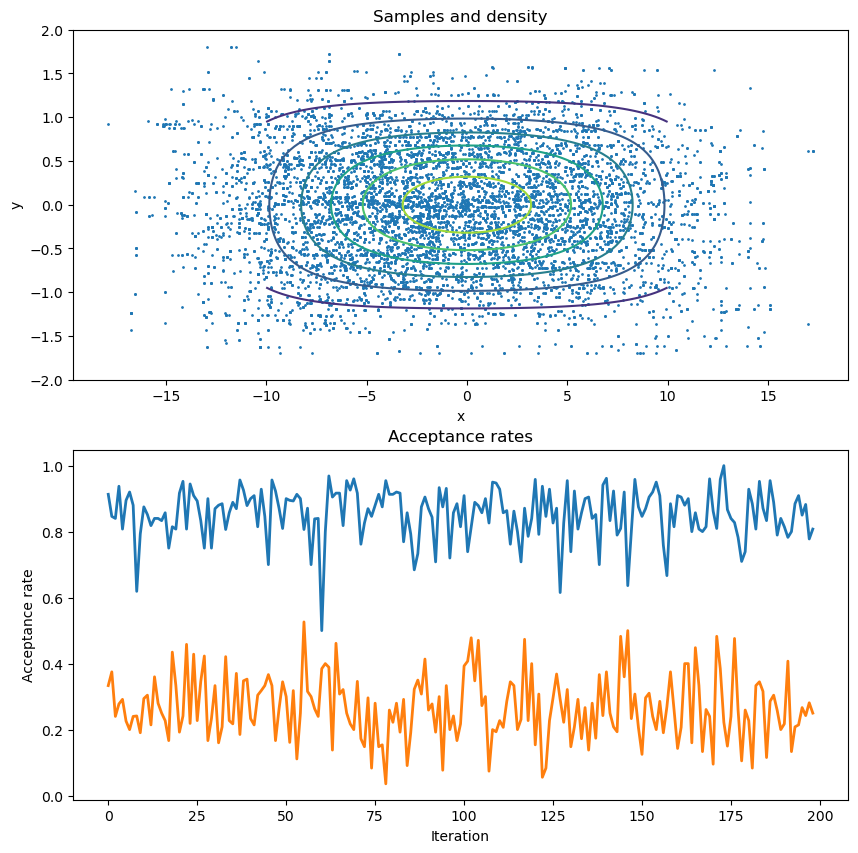

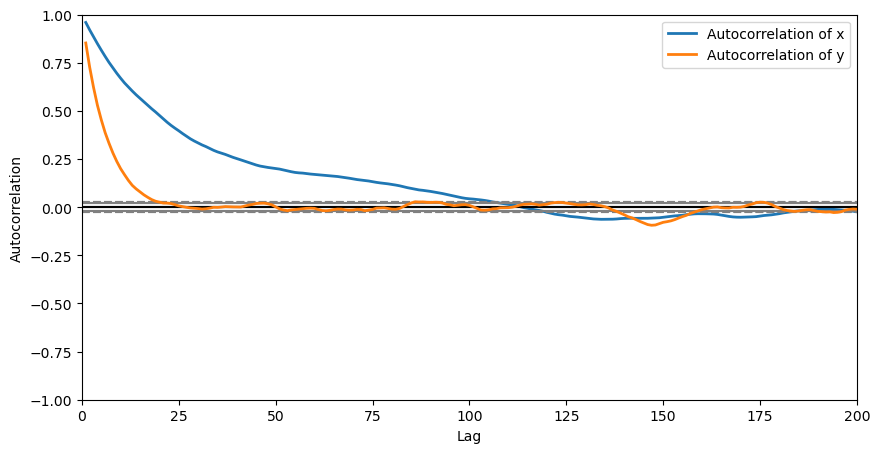

In [4]:
a = 10
sigma = (3., 3.)

x0, y0 = 1, 1
N = 10000

samples, x_acceptance_rate_list, y_acceptance_rate_list = sample_chain_P(x0, y0, sigma, a, N)

fig, ax = plt.subplots(2, 1, figsize = (10, 10))

# Plot the samples and the density
ax[0].scatter(samples[:, 0], samples[:, 1], s = 1)
plot_density(lambda x, y: log_pi(x, y, a), ax = ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Samples and density')

# Plot the acceptance rates
ax[1].plot(x_acceptance_rate_list, label = 'Acceptance rate of x', linewidth = 2)
ax[1].plot(y_acceptance_rate_list, label = 'Acceptance rate of y', linewidth = 2)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Acceptance rate')
ax[1].set_title('Acceptance rates')

# Plot the autocorrelation
plt.figure(figsize = (10, 5))
pd.plotting.autocorrelation_plot(samples[:, 0], label = 'Autocorrelation of x', linewidth = 2)
pd.plotting.autocorrelation_plot(samples[:, 1], label = 'Autocorrelation of y', linewidth = 2)
plt.xlim((0, 200))

plt.show()

We see that for $x$, the autocorrelation remains high for large values of the lag. We also see that the acceptance rate is somewhere between $80\%$ and $90\%$, wheras we usually want values between $20\%$ and $30\%$. This explains why horizontal lines can be seen: for these points, the $x$ proposal is accepted, but not the $y$ one.

All this happens because the distribution is anisotropic, so we should use different values of $\sigma$ for $x$ and $y$.

**3.**

**First method:** Increase $\sigma_1$, so that we have more exploration for the $x$-component, and therefore a lower acceptance rate.

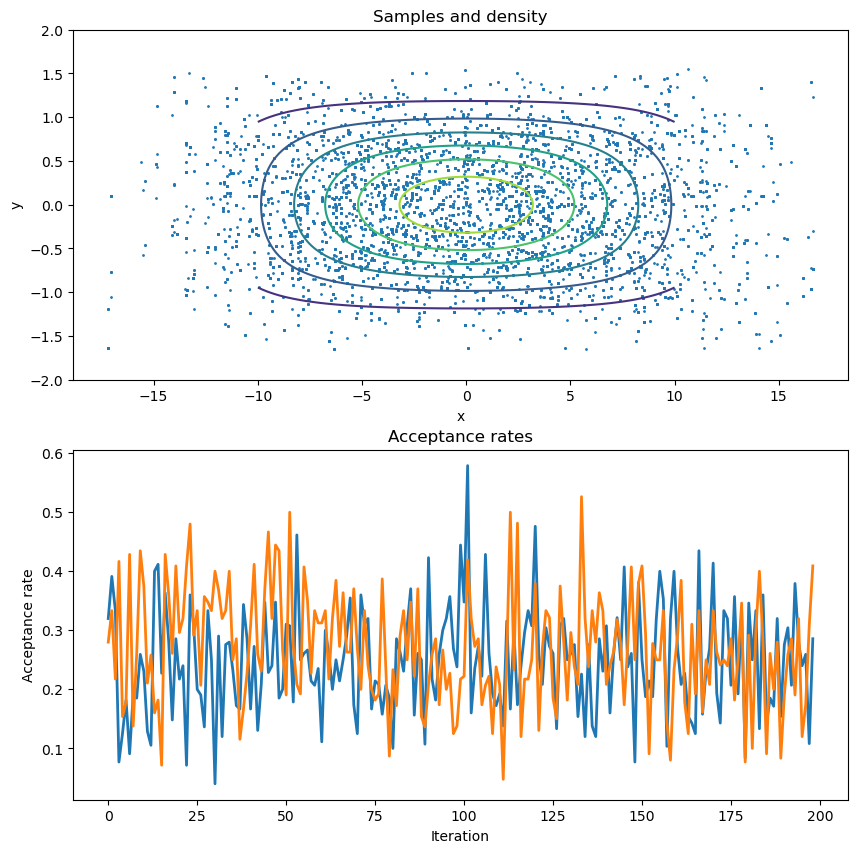

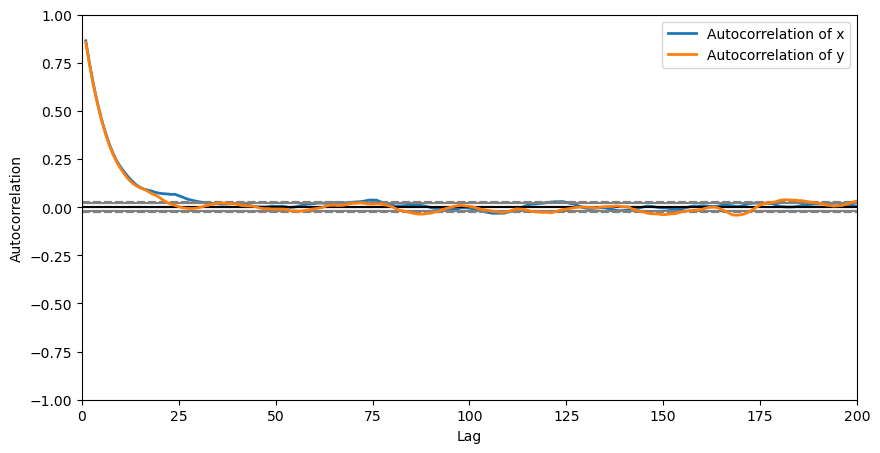

In [5]:
a = 10
sigma = (32., 3.)

x0, y0 = 1, 1
N = 10000

samples, x_acceptance_rate, y_acceptance_rate = sample_chain_P(x0, y0, sigma, a, N)

fig, ax = plt.subplots(2, 1, figsize = (10, 10))

# Plot the samples and the density
ax[0].scatter(samples[:, 0], samples[:, 1], s = 1)
plot_density(lambda x, y: log_pi(x, y, a), ax = ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Samples and density')

# Plot the acceptance rates
ax[1].plot(x_acceptance_rate, label = 'Acceptance rate of x', linewidth = 2)
ax[1].plot(y_acceptance_rate, label = 'Acceptance rate of y', linewidth = 2)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Acceptance rate')
ax[1].set_title('Acceptance rates')

# Plot the autocorrelation
plt.figure(figsize = (10, 5))
pd.plotting.autocorrelation_plot(samples[:, 0], label = 'Autocorrelation of x', linewidth = 2)
pd.plotting.autocorrelation_plot(samples[:, 1], label = 'Autocorrelation of y', linewidth = 2)
plt.xlim((0, 200))

plt.show()

We see that the acceptance rate for both $x$ and $y$ is near $30\%$, which is what is usually wanted.

The autocorrelation in $x$ now becomes close to $0$ for lower values of the lag, which is good.

And we no longer see horizontal lines in the obtained samples.

So this method seems to work rather well.

**Second method**:

Instead of choosing correctly the values of $\sigma_x$ and $\sigma_y$ from the start, we could try and adapt them progressively, using an adaptive method, hence the next parts.

##### 1.B - Adaptive Metropolis-Hastings within Gibbs sampler

**1.**

In [6]:
def adaptative_MH_Gibbs(sample0, log_density, N):
    """
    Perform an adaptative Metropolis-Hastings sampling of the target distribution

    Parameters
    ----------
    sample0 : numpy array
        Initial sample
    log_density : function
        Log density of the target distribution
    N : int
        Number of samples

    Returns
    -------
    samples : numpy array
        Array of samples
    acceptance_rate_list : list
        List of acceptance rates for each dimension
    """
    d = sample0.shape[0]

    samples = np.zeros((N, d))
    samples[0] = sample0

    acceptance_rate_list = [ [] for _ in range(d) ]
    acceptance_rates = [0] * d
    l = [0] * d
    
    for i in range(1, N):
        samples[i] = samples[i - 1].copy()
        for k in range(d):
            x = samples[i].copy()
            x_new = x.copy()
            x_new[k] = np.random.normal(x[k], np.exp(l[k]))

            log_a = np.minimum(0, log_density(x_new) - log_density(x))
            if np.log(np.random.rand()) <= log_a:
                samples[i] = x_new
                acceptance_rates[k] += 1
            else:
                samples[i] = x
            
            if i % 50 == 0:
                j = i // 50
                delta_j = min(0.01, j**(-0.5))
                if acceptance_rates[k] / 50 > 0.234:
                    l[k] += delta_j
                else:
                    l[k] -= delta_j
                acceptance_rate_list[k].append(acceptance_rates[k] / 50)
                acceptance_rates[k] = 0
    
    return samples, acceptance_rate_list

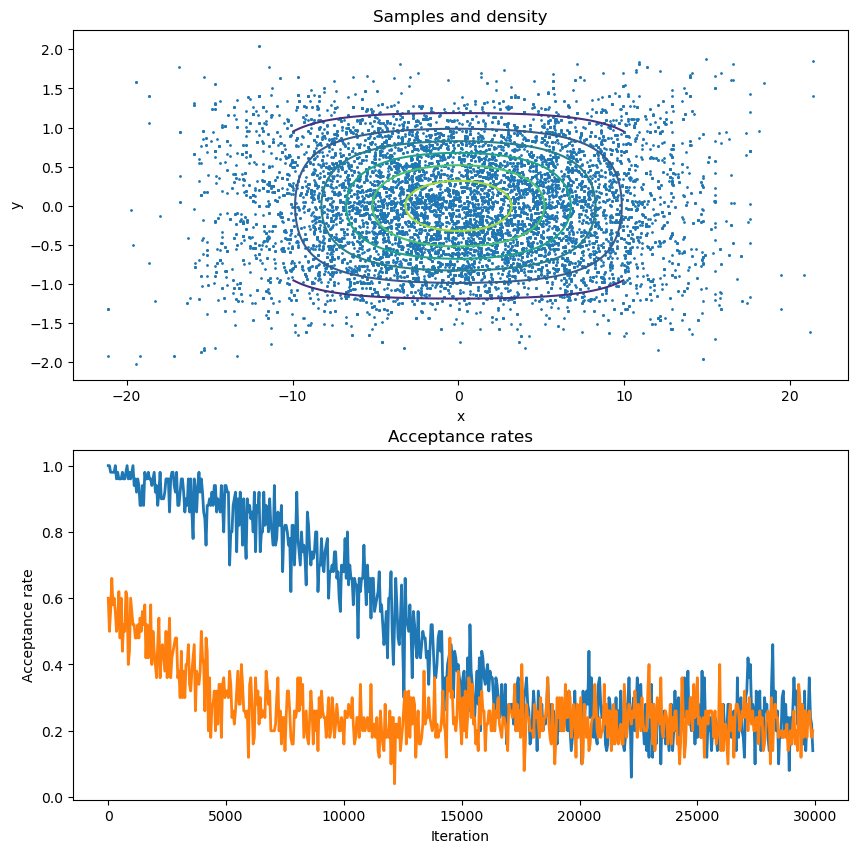

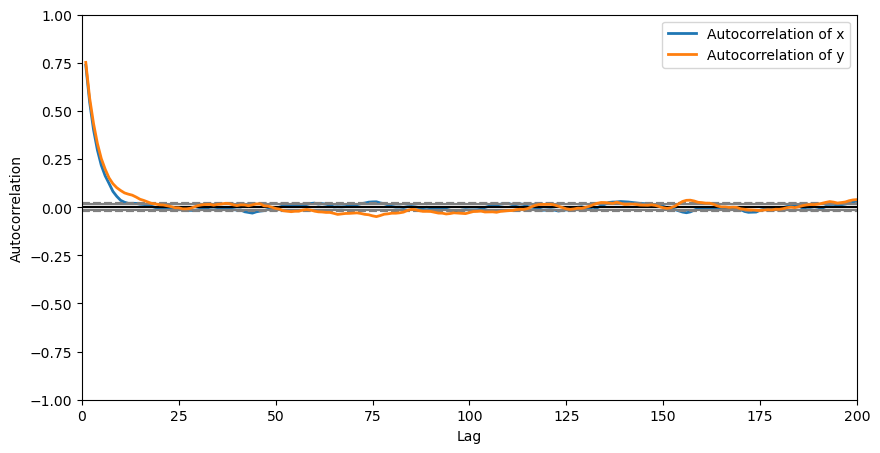

In [7]:
log_density = lambda x: log_pi(x[0], x[1], 10)
sample0 = np.array([0, 0])
samples, acceptance_rate_lists = adaptative_MH_Gibbs(sample0, log_density, 30000)
x_acceptance_rate_list, y_acceptance_rate_list = acceptance_rate_lists

fig, ax = plt.subplots(2, 1, figsize = (10, 10))

# Plot the samples and the density
ax[0].scatter(samples[len(samples) // 2:, 0], samples[len(samples) // 2:, 1], s = 1)
plot_density(lambda x, y: log_pi(x, y, 10), ax = ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Samples and density')

# Plot the acceptance rates
ax[1].plot(50 * np.arange(len(x_acceptance_rate_list)), x_acceptance_rate_list, label = 'Acceptance rate of x', linewidth = 2)
ax[1].plot(50 * np.arange(len(y_acceptance_rate_list)), y_acceptance_rate_list, label = 'Acceptance rate of y', linewidth = 2)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Acceptance rate')
ax[1].set_title('Acceptance rates')

# Plot the autocorrelation
plt.figure(figsize = (10, 5))
pd.plotting.autocorrelation_plot(samples[len(samples) // 2:, 0], label = 'Autocorrelation of x', linewidth = 2)
pd.plotting.autocorrelation_plot(samples[len(samples) // 2:, 1], label = 'Autocorrelation of y', linewidth = 2)
plt.xlim((0, 200))

plt.show()

In the above figures, we used only half the samples to plot the samples and the autocorrelation, since the first samples have not benefited from the adaptive algorithm.

We see, as was expected, that the acceptance rate eventually reaches values close to $0.2-0.3$ (though it oscillates), the displayed samples seem accurate (no horizontal lines), and the autocorrelation quickly goes to $0$ for both $x$ and $y$.

**2.**

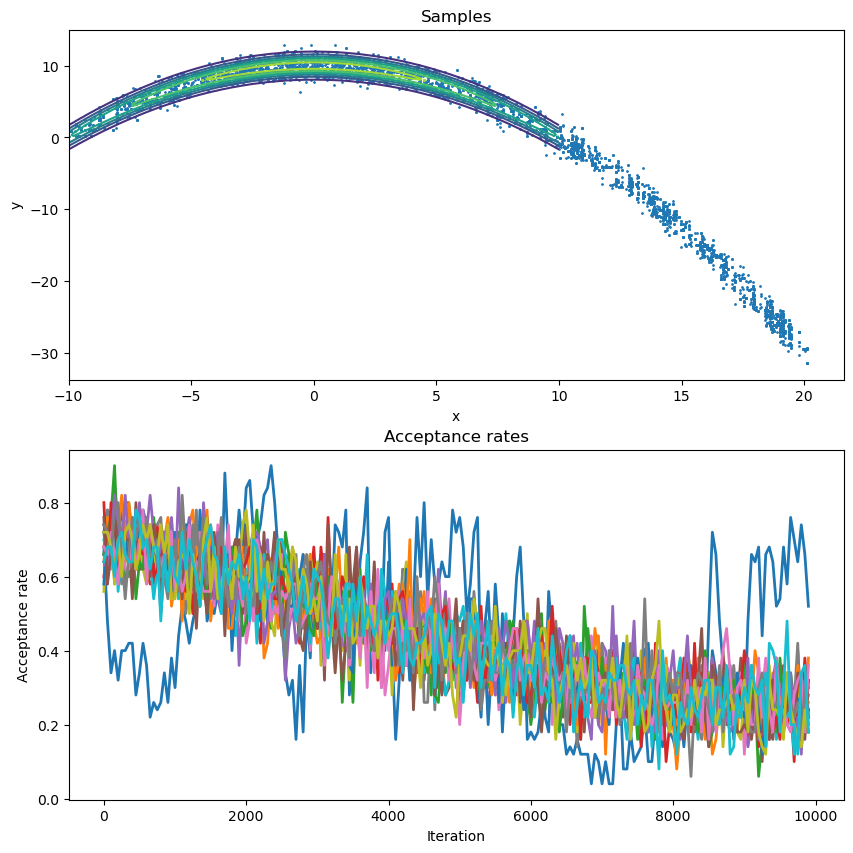

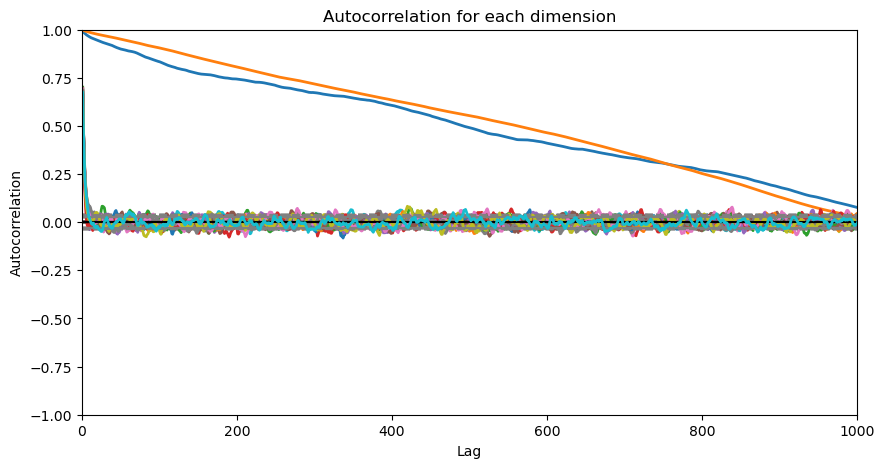

In [8]:
d = 20
B = 0.1
f = lambda x: (-x[0]**2 / 200 - (x[1] + B * x[0]**2 - 100 * B)**2 / 2 - (x[2:]**2).sum() / 2)

samples, acceptance_rate_lists = adaptative_MH_Gibbs(np.random.rand(d), f, 10000)

fig, ax = plt.subplots(2, 1, figsize = (10, 10))

# Plot the samples and the density
ax[0].scatter(samples[len(samples) // 2:, 0], samples[len(samples) // 2:, 1], s = 1)
plot_density(lambda x, y: f(np.concatenate(([x], [y]))), xmin = -10, xmax = 10, ymin = -10, ymax = 15, n = 100, ax = ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Samples')

# Plot the acceptance rates
for i in range(d):
    ax[1].plot(50 * np.arange(len(acceptance_rate_lists[i])), acceptance_rate_lists[i], label = f'Acceptance rate of x{i}', linewidth = 2)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Acceptance rate')
ax[1].set_title('Acceptance rates')

# Plot the autocorrelation
plt.figure(figsize = (10, 5))
for i in range(d):
    pd.plotting.autocorrelation_plot(samples[len(samples) // 2:, i], linewidth = 2)
plt.xlim((0, 1000))
plt.title('Autocorrelation for each dimension')

plt.show()

The result is quite good: the samples are indeed distributed as a "banana"-shaped density, the acceptance rates oscillate a lot, but around the correct value, and most of the autocorrelations go to $0$.

Because of the anisotropic distribution, using a simple Metropolis-Hastings algorithm would lead to poor results. But with an adaptive algorithm, the result is really good.

#### Exercise 2:  Sampling from multimodal distributions

#####  2.A - A toy example

**1.** We write a function `MHSRW(density, x, sigma, N)` which performs a Metropolis-Hastings Symmetric Random Walk algorithm.

In [9]:
def MHSRW(density, x, sigma, N):
    """
    Perform a Metropolis-Hastings Symmetric Random Walk (MHSRW).

    Parameters
    ----------
    density : function
        Density function
    x : numpy array
        Initial sample
    sigma : float
        Standard deviation of the proposal distribution
    N : int
        Number of iterations
    
    Returns
    -------
    samples : numpy array
        Array of samples
    """
    d = x.shape[0]

    samples = np.zeros((N, d))
    samples[0, :] = x

    for i in range(1, N):
        x_new = np.random.multivariate_normal(samples[i - 1], sigma**2 * np.eye(d))
        a = np.minimum(1, density(x_new) / density(samples[i - 1]))

        if np.random.rand() <= a:
            samples[i] = x_new
        else:
            samples[i] = samples[i - 1]

    return samples

**2.**

In [10]:
def pi(x, mu, sigma, w):
    """ Density of the mixture of Gaussian """
    temp = ((x[None, :] - mu)**2).sum(axis = 1)

    return (w / (2 * np.pi * sigma**2) * np.exp(- 1 / (2 * sigma**2) * temp)).sum()

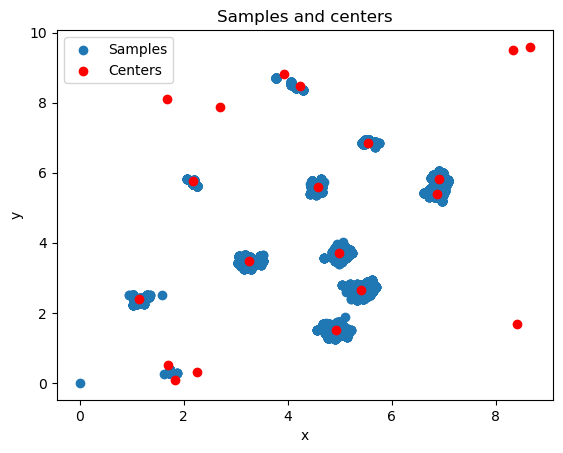

In [11]:
n = 20
d = 2
sigma = 0.1 * np.ones(n)
w = 0.05 * np.ones(n)
x = np.ones(d)
mu = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.70, 0.50],
               [4.59, 5.60], [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39],
               [8.33, 9.50], [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])

density = lambda x: pi(x, mu, sigma, w)

samples = MHSRW(density, np.zeros(d), sigma = 1, N = 10000)

plt.scatter(samples[:, 0], samples[:, 1], label = 'Samples')
plt.scatter(mu[:, 0], mu[:, 1], label = 'Centers', color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples and centers')
plt.legend()
plt.show()

We see that the Metropolis-Hastings symmetric random walk algorithm only explores a few modes of the distribution (which are close to the initial point).

In [12]:
def adaptative_MHSRW(x, density, N = 10000):
    """
    Perform an adaptative Metropolis-Hastings Symmetric Random Walk (MHSRW).

    Parameters
    ----------
    x : numpy array
        Initial sample
    density : function
        Density function

    Returns
    -------
    samples : numpy array
        Array of samples
    """
    d = x.shape[0]
    samples = np.zeros((N, d))
    samples[0] = x

    l = 0
    acceptance = 0

    for i in range(1, N):
        x = samples[i - 1].copy()
        x_new = np.random.normal(x, np.exp(l))
        alpha = min(1, density(x_new) / density(x))
        if np.random.uniform() <= alpha:
            samples[i] = x_new
            acceptance += 1
        else:
            samples[i] = x

        if i % 50 == 0:
            j = i // 50
            delta_j = min(0.01, j**(-0.5))
            if acceptance / 50 > 0.234:
                l += delta_j
            else:
                l -= delta_j
            acceptance = 0
    
    return samples

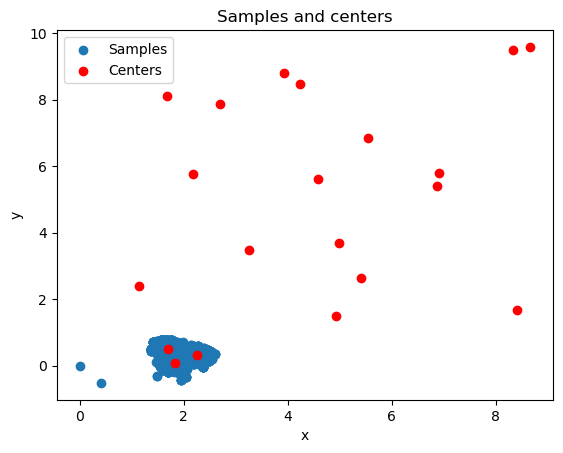

In [13]:
samples = adaptative_MHSRW(np.zeros(d), density, N = 10000)

plt.scatter(samples[:, 0], samples[:, 1], label = 'Samples')
plt.scatter(mu[:, 0], mu[:, 1], label = 'Centers', color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples and centers')
plt.legend()
plt.show()

We see that the adaptive Metropolis-Hastings algorithm similarly fails to sample from $\pi$.

##### 2.B - Parallel Tempering

**1.**

In [14]:
def parallel_tempering(x, density, T, N):
    """
    Perform a parallel tempering algorithm.

    Parameters
    ----------
    x : numpy array
        Initial sample
    density : function
        Density function
    T : list
        List of temperatures
    N : int
        Number of iterations

    Returns
    -------
    samples : numpy array
        Array of samples
    """
    K = len(T)
    d = mu.shape[1]

    samples = np.zeros((K, N + 1, d))
    samples[:, 0, :] = x
    
    for n in tqdm(range(N), total = N, desc = 'Iterations'):
        # Update the samples
        for i in range(len(T)):
            for k in range(d):
                X_new = samples[i, n, :].copy()
                X_new[k] = np.random.normal(samples[i, n, k], 0.25 * np.sqrt(T[i]))
                log_a = np.minimum(0, (np.log(density(X_new)) - np.log(density(samples[i, n]))) / T[i])
                if np.log(np.random.rand()) <= log_a:
                    samples[i, n + 1, k] = X_new[k]
                else:
                    samples[i, n + 1, k] = samples[i, n, k]
        
        # Swap the samples
        i = np.random.randint(0, len(T))
        j = np.random.choice([i - 1, i + 1])
        if i == 0:
            j = i + 1
        elif i == len(T) - 1:
            j = i - 1

        num = (density(samples[j, n + 1, :])**(1 / T[i])) * (density(samples[i, n + 1, :])**(1 / T[j]))
        den = (density(samples[i, n + 1, :])**(1 / T[i])) * (density(samples[j, n + 1, :])**(1 / T[j]))
        alpha = min(1, num / den)
 
        if np.random.rand() <= alpha:
            samples[i, n + 1, :], samples[j, n + 1, :] = samples[j, n + 1, :], samples[i, n + 1, :]
    return samples

**2.**

Iterations:   0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_864223/2595004856.py:33: RuntimeWarning: divide by zero encountered in log
  log_a = np.minimum(0, (np.log(density(X_new)) - np.log(density(samples[i, n]))) / T[i])
Iterations: 100%|██████████| 10000/10000 [00:04<00:00, 2282.50it/s]


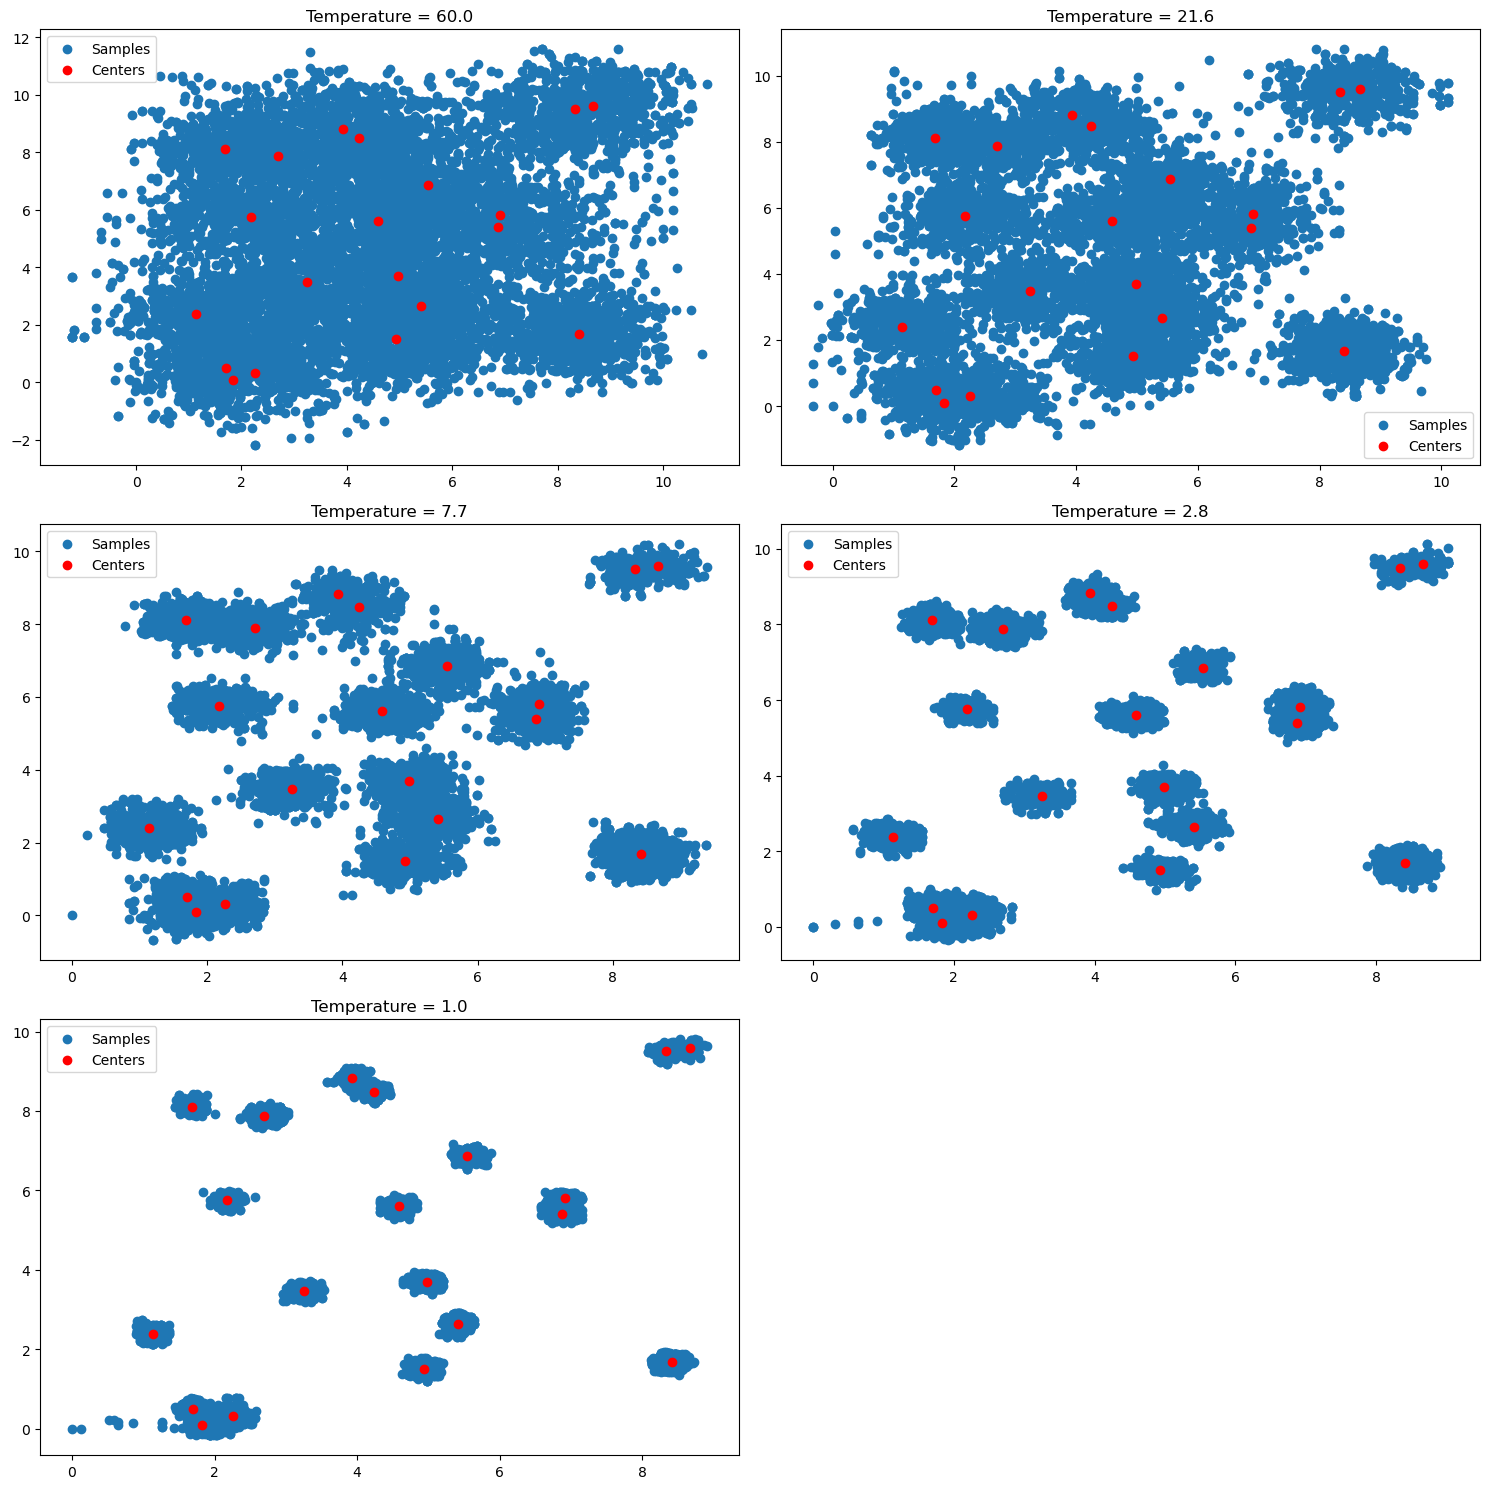

In [15]:
T = np.array([60., 21.6, 7.7, 2.8, 1.])
d = 2

x = np.zeros(d)
samples = parallel_tempering(x, density, T, 10000)

n_col = 2
n_row = np.ceil(len(T) / n_col).astype(int)
plt.figure(figsize = (15, 15))

for i in range(len(T)): 
    plt.subplot(n_row, n_col, i + 1)
    plt.scatter(samples[i, :, 0], samples[i, :, 1], label = 'Samples')
    plt.scatter(mu[:, 0], mu[:, 1], label = 'Centers', color = 'red')
    plt.legend()
    plt.title(f'Temperature = {T[i]}')

plt.tight_layout()
plt.show()

The result is much better than before. The parallel tempering algorithm is able to sample all modes, even though they can be far apart. Moreover, when the temperature decreases, the sampling becomes more accurate (because the true density corresponds to $T = 1$).

#### Exercise 3: Bayesian analysis of a one-way random effects model

**1.**
We first have, using de Bayes:
$$
p(x, \mu, \sigma^2, \tau^2 \mid y)
\propto
p(x, \mu, \sigma^2, \tau^2) p(y \mid x, \mu, \sigma^2, \tau^2)
=
p(\mu, \sigma^2, \tau^2) p(x \mid \mu, \sigma^2, \tau^2) p(y \mid x, \mu, \sigma^2, \tau^2)
$$

- Using $Y_{i, j} = X_i + \varepsilon_{i, j}$, we have
$$
p(y \mid x, \mu, \sigma^2, \tau^2)
\propto
\frac{1}{(\tau^2)^{kN/2}} \prod\limits_{i = 1}^N \prod\limits_{j = 1}^{k_i} \exp\left( -\frac{1}{2\tau^2} \left( y_{i, j} - x_i \right)^2 \right).
$$

- Using the fact that $X_i \sim \mathcal{N}(\mu, \sigma^2)$, we have
$$
p(x \mid \mu, \sigma^2, \tau^2)
\propto
\frac{1}{(\sigma^2)^{N/2}} \prod\limits_{i = 1}^N \exp\left( -\frac{1}{2\sigma^2} \left( x_i - \mu \right)^2 \right).
$$

- Using the prior on $(\mu, \sigma^2, \tau^2)$, we have
$$
p(\mu, \sigma^2, \tau^2)
=
\pi_{prior}(\mu, \sigma^2, \tau^2)
\propto
\frac{1}{\sigma^{2(1+\alpha)}} \exp\left( -\frac{\beta}{\sigma^2} \right) \frac{1}{\tau^{2(1+\gamma)}} \exp\left( -\frac{\beta}{\tau^2} \right).
$$

So in the end:
$$
\boxed{
    p(x, \mu, \sigma^2, \tau^2 \mid y)
    \propto
    \left(\frac{1}{\tau^2} \right)^{kN/2 + 1 + \gamma}
    \left(\frac{1}{\sigma^2} \right)^{N/2 + 1 + \alpha}
    \exp\left( -\frac{1}{2\tau^2} \sum\limits_{i = 1}^N \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 - \frac{1}{2\sigma^2} \sum\limits_{i = 1}^N \left( x_i - \mu \right)^2 - \frac{\beta}{\sigma^2} - \frac{\beta}{\tau^2} \right)
}.
$$

**2.** To use Gibbs sampling for $(\sigma^2, \tau^2, \mu, X)$, we need to compute some densities using the previous question:

- $p(X \mid Y, \sigma^2, \tau^2, \mu) \propto \exp\left( -\dfrac{1}{2\tau^2} \sum\limits_{i = 1}^N \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 - \dfrac{1}{2\sigma^2} \sum\limits_{i = 1}^N \left( x_i - \mu \right)^2\right)$

- $p(\sigma^2 \mid Y, X, \tau^2, \mu) \propto\left(\dfrac{1}{\sigma^2} \right)^{N/2 + 1 + \alpha}\exp\left( - \dfrac{1}{2\sigma^2} \sum\limits_{i = 1}^N \left( x_i - \mu \right)^2 - \dfrac{\beta}{\sigma^2} \right)$

- $p(\tau^2 \mid Y, X, \sigma^2, \mu) \propto \left(\dfrac{1}{\tau^2} \right)^{kN/2 + 1 + \gamma} \exp\left( -\dfrac{1}{2\tau^2} \sum\limits_{i = 1}^N \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 - \dfrac{\beta}{\tau^2} \right)$

- $p(\mu \mid Y, X, \sigma^2, \tau^2) \propto \exp\left( - \dfrac{1}{2\sigma^2} \sum\limits_{i = 1}^N \left( x_i - \mu \right)^2 \right) \propto \exp\left( - \dfrac{N}{2\sigma^2} \left( \mu - \dfrac{1}{N} \sum\limits_{i = 1}^N x_i \right)^2 \right) $.

From this, we deduce some conditional laws. For instance,
$$
\begin{align*}
    p(X \mid Y, \sigma^2, \tau^2, \mu)
    &\propto \exp\left( -\dfrac{1}{2\tau^2} \sum\limits_{i = 1}^N \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 - \dfrac{1}{2\sigma^2} \sum\limits_{i = 1}^N \left( x_i - \mu \right)^2\right) \\
    &= \exp\left( -\dfrac{1}{2} \sum\limits_{i = 1}^N \left( \dfrac{1}{\sigma^2} \left( x_i - \mu \right)^2 + \dfrac{1}{\tau^2} \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 \right) \right) \\
    &\propto \exp\left( -\dfrac{1}{2} \sum\limits_{i = 1}^N \left( \left( \dfrac{\tau^2 + \sigma^2 k_i}{\sigma^2 \tau^2} \right) x_i^2 - 2 \left( \dfrac{\mu \tau^2 + \sigma^2 \sum\limits_{j = 1}^{k_i} y_{i, j}}{\tau^2 \sigma^2} \right) x_i \right) \right) \\
    &= \exp\left( -\dfrac{1}{2} \sum\limits_{i = 1}^N \dfrac{\tau^2 + \sigma^2 k_i}{\sigma^2 \tau^2} \left( x_i^2 - 2 \left( \dfrac{\mu \tau^2 + \sigma^2 \sum\limits_{j = 1}^{k_i} y_{i, j}}{\tau^2 + \sigma^2 k_i} \right) x_i \right) \right) \\
    &\propto \exp\left( -\dfrac{1}{2} \sum\limits_{i = 1}^N \dfrac{\tau^2 + \sigma^2 k_i}{\sigma^2 \tau^2} \left( x_i - \dfrac{\mu \tau^2 + \sigma^2 \sum\limits_{j = 1}^{k_i} y_{i, j}}{\tau^2 + \sigma^2 k_i} \right)^2 \right) \\
    &= \prod\limits_{i = 1}^N \exp\left( -\dfrac{1}{2} \dfrac{\tau^2 + \sigma^2 k_i}{\sigma^2 \tau^2} \left( x_i - \dfrac{\mu \tau^2 + \sigma^2 \sum\limits_{j = 1}^{k_i} y_{i, j}}{\tau^2 + \sigma^2 k_i} \right)^2 \right),
\end{align*}
$$
so conditionally to $Y, \sigma^2, \tau^2, \mu$, the $X_i$'s are independent, and $\boxed{ X_i \mid Y, \sigma^2, \tau^2, \mu \sim \mathcal{N}\left( \dfrac{\mu \tau^2 + \sigma^2 \sum\limits_{j = 1}^{k_i} y_{i, j}}{\tau^2 + \sigma^2 k_i}, \dfrac{\tau^2 \sigma^2}{k_i \sigma^2 + \tau^2} \right) }$.

Similarly, we obtain

- $\boxed{\sigma^2 \mid Y, X, \tau^2, \mu \sim \Gamma^{-1} \left( \alpha + \dfrac{N}{2}, \beta + \dfrac{1}{2} \sum\limits_{i = 1}^N (x_i - \mu)^2 \right)}$

- $\boxed{\tau^2 \mid Y, X, \sigma^2, \mu \sim \Gamma^{-1} \left( \gamma + \dfrac{kN}{2}, \beta + \dfrac{1}{2} \sum\limits_{i = 1}^N \sum\limits_{j = 1}^{k_i} (x_i - y_{i, j})^2 \right)}$

- $\boxed{ \mu \mid Y, X, \sigma^2, \tau^2 \sim \mathcal{N}\left( \dfrac{1}{N} \sum\limits_{i = 1}^N x_i, \dfrac{\sigma^2}{N} \right) }$.

We then write a function `Gibbs_sampler(Y, sigma2_0, tau2_0, mu_0, X_0, alpha, beta, gamma, N, k, n_samples)` which uses Gibbs sampler which updates in turn $\sigma^2, \tau^2, \mu, X$ one at a time.

In [16]:
def Gibbs_sampler(Y, sigma2_0, tau2_0, mu_0, X_0, alpha, beta, gamma, N, k, n_samples):
    sigma2_list, sigma2 = [], sigma2_0
    tau2_list, tau2 = [], tau2_0
    mu_list, mu = [], mu_0
    X_list, X = [], X_0

    for _ in range(n_samples):
        sigma2 = sp.stats.invgamma.rvs(a = alpha + N / 2, scale = beta + 0.5 * np.sum((X - mu)**2))
        tau2 = sp.stats.invgamma.rvs(a = gamma + N * k / 2, scale = beta + 0.5 * np.sum((Y.T - X)**2))
        mu = np.random.normal(loc = np.mean(X), scale = np.sqrt(sigma2 / N))
        
        for i in range(N):
            mean = (tau2 * mu + sigma2 * np.sum(Y[i, :])) / (tau2 + sigma2 * k)
            std = np.sqrt((sigma2 * tau2) / (k * sigma2 + tau2))
            X[i] = np.random.normal(loc = mean, scale = std)
        
        sigma2_list.append(sigma2)
        tau2_list.append(tau2)
        mu_list.append(mu)
        X_list.append(X)
    
    return sigma2_list, tau2_list, mu_list, X_list

**3.**

We first compute the law of $X, \mu \mid \sigma^2, \tau^2$.

$$
\begin{align*}
    p(x, \mu \mid y, \sigma^2, \tau^2)
    & \propto
    \exp\left( -\frac{1}{2\tau^2} \sum\limits_{i = 1}^N \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 - \frac{1}{2\sigma^2} \sum\limits_{i = 1}^N \left( x_i - \mu \right)^2 \right) \\
    & =
    \prod\limits_{i = 1}^N \exp\left( -\frac{1}{2\tau^2} \sum\limits_{j = 1}^{k_i} \left( y_{i, j} - x_i \right)^2 - \frac{1}{2\sigma^2} \left( x_i - \mu \right)^2 \right) \\
    & \propto
    \prod\limits_{i = 1}^N \exp\left( -\frac{1}{2} \left( \left( \dfrac{k_i}{\tau^2} + \dfrac{1}{\sigma^2} \right) x_i^2 - 2 \left( \dfrac{\sum\limits_{j = 1}^{k_i} y_{i, j}}{\tau^2} + \dfrac{\mu}{\sigma^2} \right) x_i + \dfrac{1}{\sigma^2} \mu^2 \right) \right) \\
    & \propto
    \exp\left( - \dfrac{1}{2} \left(\begin{pmatrix} x \\ \mu \end{pmatrix} - m \right)^T \Sigma^{-1} \left(\begin{pmatrix} x \\ \mu \end{pmatrix} - m \right) \right)
\end{align*}
$$
where
$$
\boxed{
\Sigma^{-1}
=
\begin{pmatrix}
    \dfrac{k_1}{\tau^2} + \dfrac{1}{\sigma^2} & 0 & \cdots & 0 & -1/\sigma^2 \\
    0 & \dfrac{k_2}{\tau^2} + \dfrac{1}{\sigma^2} & \cdots & 0 & -1/\sigma^2 \\
    0 & 0 & \ddots & \vdots & \vdots \\
    0 & 0 & \cdots & \dfrac{k_N}{\tau^2} + \dfrac{1}{\sigma^2} & -1/\sigma^2 \\
    -1/\sigma^2 & -1/\sigma^2 & \cdots & -1/\sigma^2 & N / \sigma^2
\end{pmatrix}
}
$$
and
$$
\boxed{
m
=
\Sigma \begin{pmatrix} \dfrac{1}{\tau^2} \sum\limits_{j = 1}^{k_1} y_{1, j}, & \cdots & \dfrac{1}{\tau^2} \sum\limits_{j = 1}^{k_N} y_{N, j}, & 0 \end{pmatrix}
}
$$

So $X, \mu \mid Y, \sigma^2, \tau^2 \sim \mathcal{N}( m, \Sigma )$.

In [17]:
def block_Gibbs_sampler(Y, sigma2_0, tau2_0, mu_0, X_0, alpha, beta, gamma, N, k, n_samples):
    sigma2_list, sigma2 = [], sigma2_0
    tau2_list, tau2 = [], tau2_0
    mu_list, mu = [], mu_0
    X_list, X = [], X_0

    inv_cov = np.zeros((N + 1, N + 1))
    Y_ = np.zeros(N+1)
    Y_[:N] = np.sum(Y, axis = 1).reshape(N)
    
    for _ in range(n_samples):
        sigma2 = sp.stats.invgamma.rvs(a = alpha + N / 2, scale = beta + 0.5 * np.sum((X - mu)**2))
        tau2 = sp.stats.invgamma.rvs(a = gamma + N * k / 2, scale = beta + 0.5 * np.sum((Y.T - X)**2))

        for i in range(N):
            inv_cov[i, i] = k / tau2 + 1 / sigma2
        inv_cov[:, N] = -1 / sigma2
        inv_cov[N, :] = -1 / sigma2
        inv_cov[N, N] = N / sigma2
        
        cov = np.linalg.pinv(inv_cov)
        Y_temp = Y_.copy()
        Y_temp[-1] = 0
        mean = cov @ Y_temp / tau2
        
        X_mu = np.random.multivariate_normal(mean = mean, cov = cov)
        X = X_mu[:N]
        mu = X_mu[N]
        
        sigma2_list.append(sigma2)
        tau2_list.append(tau2)
        mu_list.append(mu)
        X_list.append(X)
    
    return sigma2_list, tau2_list, mu_list, X_list

**4.**

The first algorithm is simple since it relies on efficient sampling methods from distributions like the normal and (inverse) gamma distributions. In contrast, the second algorithm is more complicated because it involves drawing samples from a multivariate Gaussian distribution.

A main difference between the algorithms is the impact on $\mu$: in the first algorithm, $\mu = \dfrac{1}{N} \sum\limits_{i = 1}^N X_i$, whereas in the second algorithm, $\mathbb{E}\left[ \mu \mid Y, X, \sigma^2, \tau^2 \right] = 0$. The last column and last row of $\Sigma^{-1}$ show that $\mu$ adds some sort of dependence between the components of $X$.

Regarding the sampling method itself, Gibbs sampling is known for its simplicity in implementation, but it can struggle when dealing with complex problems containing many loops, which may lead to slow mixing. Block Gibbs sampling offers a more efficient alternative by jointly sampling multiple variables rather than sampling one variable at a time, which can significantly improve mixing speed. 

**5.** We first write a function `generate_data(N, K, alpha, beta, gamma, mu)` to generate the data.

In [18]:
def generate_data(N, K, alpha, beta, gamma, mu):
    sigma2 = sp.stats.invgamma.rvs(a = alpha, scale = beta)
    tau2 = sp.stats.invgamma.rvs(a = gamma, scale = beta)
    X = np.random.normal(mu, np.sqrt(sigma2), size = N)
    epsilon = np.random.normal(0, np.sqrt(tau2), size = (N, K))
    y = X[:, None] + epsilon
    return y, X, sigma2, tau2

N = 50
K = 10
alpha = 4
beta = 2
gamma = 1
mu = 2

y, X, sigma2, tau2 = generate_data(N, K, alpha, beta, gamma, mu)

Then, we look at the result for Gibbs sampler:

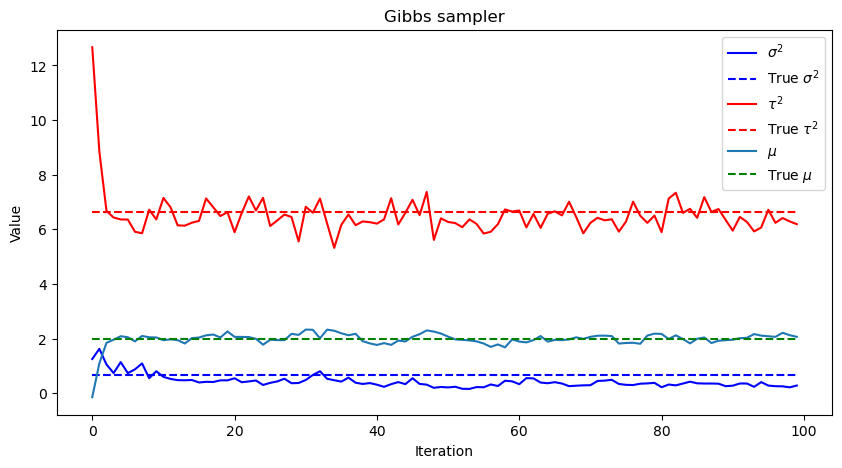

Variance of the samples for sigma^2: 0.054
Variance of the samples for tau^2: 0.595
Variance of the samples for mu: 0.074


In [19]:
sigma2_0 = 1
tau2_0 = 1
mu_0 = 1
X_0 = np.zeros(N)
n_samples = 100

Z = Gibbs_sampler(y, sigma2_0, tau2_0, mu_0, X_0, alpha, beta, gamma, N, K, n_samples)
Z_true = np.zeros((n_samples, N + 3))
Z_true[:, 0] = sigma2
Z_true[:, 1] = tau2
Z_true[:, 2] = mu
Z_true[:, 3:] = X


plt.figure(figsize = (10, 5))

plt.plot(Z[0], label = r'$\sigma^2$', color = 'blue')
plt.plot(Z_true[:, 0], label = r"True $\sigma^2$", linestyle = '--', color = 'blue')

plt.plot(Z[1], label = r'$\tau^2$', color = 'red')
plt.plot(Z_true[:, 1], label = r"True $\tau^2$", linestyle = '--', color = 'red')

plt.plot(Z[2], label = r'$\mu$')
plt.plot(Z_true[:, 2], label = r"True $\mu$", linestyle = '--', color = 'green')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Gibbs sampler')
plt.legend()
plt.show()

# Variance of the samples
print(f"Variance of the samples for sigma^2: {np.var(Z[0]):.3f}")
print(f"Variance of the samples for tau^2: {np.var(Z[1]):.3f}")
print(f"Variance of the samples for mu: {np.var(Z[2]):.3f}")

And we look at the result for Gibbs block sampler:

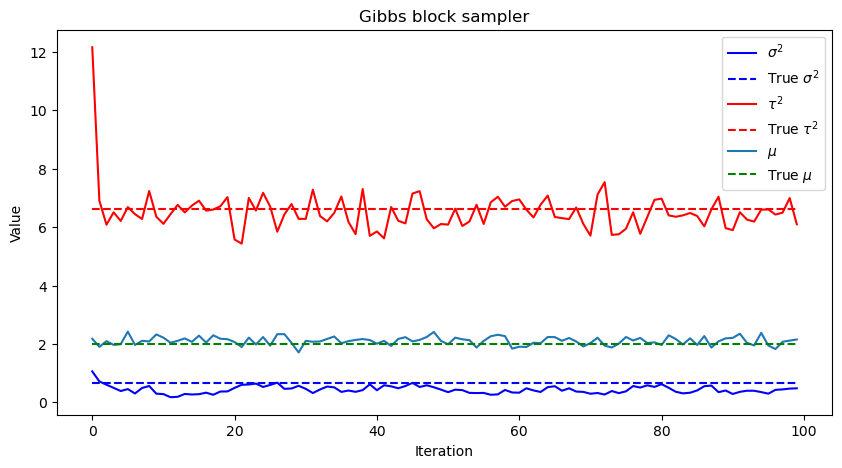

Variance of the samples for sigma^2: 0.017
Variance of the samples for tau^2: 0.517
Variance of the samples for mu: 0.020


In [20]:
sigma2_0 = 1
tau2_0 = 1
mu_0 = 1
X_0 = np.zeros(N)
n_samples = 100

Z = block_Gibbs_sampler(y, sigma2_0, tau2_0, mu_0, X_0, alpha, beta, gamma, N, K, n_samples)
Z_true = np.zeros((n_samples, N + 3))
Z_true[:, 0] = sigma2
Z_true[:, 1] = tau2
Z_true[:, 2] = mu
Z_true[:, 3:] = X


plt.figure(figsize = (10, 5))

plt.plot(Z[0], label = r'$\sigma^2$', color = 'blue')
plt.plot(Z_true[:, 0], label = r"True $\sigma^2$", linestyle = '--', color = 'blue')

plt.plot(Z[1], label = r'$\tau^2$', color = 'red')
plt.plot(Z_true[:, 1], label = r"True $\tau^2$", linestyle = '--', color = 'red')

plt.plot(Z[2], label = r'$\mu$')
plt.plot(Z_true[:, 2], label = r"True $\mu$", linestyle = '--', color = 'green')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Gibbs block sampler')
plt.legend()
plt.show()

# Variance of the samples
print(f"Variance of the samples for sigma^2: {np.var(Z[0]):.3f}")
print(f"Variance of the samples for tau^2: {np.var(Z[1]):.3f}")
print(f"Variance of the samples for mu: {np.var(Z[2]):.3f}")

We observe that both methods (Gibbs sampling and Gibbs block sampling) lead to rather accurate values for $\sigma^2, \tau^2$ and $\mu$.

However, the oscillations of these estimators are smaller for block sampling, as can be seen with the above variances.